In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet("../data/raw/data.parquet")

In [3]:
df['quarter'] = df['date'].dt.to_period("Q")

In [4]:
df.target = np.nan
df.loc[df.loan_status.isin(['Fully Paid']), 'target'] = 0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target'] = 1
df = df[df['target'].isin([0,1])]

In [5]:
sam_df = df[['quarter', "grade", "target"]]

In [6]:
sam_df

,quarter,grade,target
0,2018Q1,E,0.0
1,2018Q1,C,1.0
6,2018Q1,B,0.0
13,2018Q1,D,0.0
14,2018Q1,B,0.0
...,...,...,...
1159860,2020Q3,A,0.0
1159862,2020Q3,C,0.0
1159904,2020Q3,A,0.0
1159989,2020Q3,B,0.0


In [7]:
import matplotlib.pyplot as plt

In [19]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [1]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict(self, X):
        predictions = []
        for sample in X:
            predictions.append(self.predict_sample(sample))
        return np.array(predictions)

    def predict_sample(self, sample):
        node = self.tree
        while node.get('value') is None:
            if sample[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return {'value': y[0]}

        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': self.get_most_common_label(y)}

        if len(X) < self.min_samples_split:
            return {'value': self.get_most_common_label(y)}

        best_feature, best_threshold = self.find_best_split(X, y)
        if best_feature is None or best_threshold is None:
            return {'value': self.get_most_common_label(y)}

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        if len(X[left_indices]) < self.min_samples_leaf or len(X[right_indices]) < self.min_samples_leaf:
            return {'value': self.get_most_common_label(y)}

        left_tree = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self.build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold, 'left': left_tree, 'right': right_tree}

    # def find_best_split(self, X, y):
    #     best_gini = float('inf')
    #     best_feature = None
    #     best_threshold = None
# 
    #     if self.max_features is not None:
    #         num_features = min(self.max_features, X.shape[1])
    #         feature_indices = np.random.choice(range(X.shape[1]), num_features, replace=False)
    #         X_subset = X[:, feature_indices]
    #     else:
    #         feature_indices = range(X.shape[1])
    #         X_subset = X
# 
    #     for feature in feature_indices:
    #         thresholds = np.unique(X_subset[:, feature])
    #         for threshold in thresholds:
    #             gini = self.calculate_gini(X_subset, y, feature, threshold)
    #             if gini < best_gini:
    #                 best_gini = gini
    #                 best_feature = feature
    #                 best_threshold = threshold
# 
    #     return best_feature, best_threshold
    
    def find_best_split(self, X: pd.DataFrame, y):
        best_score = 0
        best_threshold = None
        best_feature = None
        
        if self.max_features is not None:
            num_features = min(self.max_features, X.shape[1])
            features = np.random.choice(X.columns, num_features, replace=False)
            X_subset = X[features].copy(deep=True)
        else:
            features = X.columns
            X_subset = X.copy(deep=True)
            
        # кодируем категории как badrate
        features = np.delete(features, np.where(features == self.dt_group_col))
        
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:  
            futures = [
                executor.submit(self.find_best_split_for_feature, X, y, feature)
                for X, y, feature
                in zip(itertools.repeat(X_subset), 
                       itertools.repeat(y), 
                       features, 
                      )
            ]
            try:    
                for future in futures:
                    feature, threshold, score = future.result() 
                    if score > best_score:
                        best_score = score
                        best_feature = feature
                        best_threshold = threshold
            except KeyboardInterrupt:
                executor._threads.clear()
                concurrent.futures.thread._threads_queues.clear()
                raise

        return best_feature, best_threshold

    def calculate_gini(self, X, y, feature, threshold):
        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        left_labels = y[left_indices]
        right_labels = y[right_indices]

        left_counts = np.bincount(left_labels)
        right_counts = np.bincount(right_labels)

        left_probs = left_counts / np.sum(left_counts)
        right_probs = right_counts / np.sum(right_counts)

        left_gini = 1 - np.sum(left_probs ** 2)
        right_gini = 1 - np.sum(right_probs ** 2)

        gini = (np.sum(left_counts) * left_gini + np.sum(right_counts) * right_gini) / len(y)

        return gini

    def get_most_common_label(self, y):
        unique_labels, counts = np.unique(y, return_counts=True)
        most_common_label = unique_labels[np.argmax(counts)]
        return most_common_label

In [9]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


class DecisionTreeClassifier:
    def __init__(
        self,
        max_depth=None, 
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None, 
        dt_group_col=None,
        n_jobs=4,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.tree = None
        self.dt_group_col = dt_group_col
        self.n_jobs = n_jobs

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict(self, X):
        predictions = []
        for sample in X:
            predictions.append(self.predict_sample(sample))
        return np.array(predictions)

    def predict_sample(self, sample):
        node = self.tree
        while node.get('value') is None:
            if sample[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return {'value': y[0]}

        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': self.get_most_common_label(y)}

        if len(X) < self.min_samples_split:
            return {'value': self.get_most_common_label(y)}

        best_feature, best_threshold = self.find_best_split(X, y)
        if best_feature is None or best_threshold is None:
            return {'value': self.get_most_common_label(y)}

        left_indices = X[best_feature] <= best_threshold
        right_indices = X[best_feature] > best_threshold

        if len(X.loc[left_indices]) < self.min_samples_leaf or len(X.loc[right_indices]) < self.min_samples_leaf:
            return {'value': self.get_most_common_label(y)}
        
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            future_left = executor.submit(self.build_tree, X.loc[left_indices], y[left_indices], depth + 1)
            future_right = executor.submit(self.build_tree, X.loc[right_indices], y[right_indices], depth + 1)
            left_tree = future_left.result()
            right_tree = future_right.result()

        return {'feature': best_feature, 'threshold': best_threshold, 'left': left_tree, 'right': right_tree}

    # def find_best_split(self, X: pd.DataFrame, y):
    #     best_score = float('inf')
    #     best_feature = None
    #     best_threshold = None
# 
    #     if self.max_features is not None:
    #         num_features = min(self.max_features, X.shape[1])
    #         features = np.random.choice(X.columns, num_features, replace=False)
    #         X_subset = X[features]
    #     else:
    #         features = X.columns
    #         X_subset = X
    #     
    #     # кодируем категории как badrate
    #     features = np.delete(features, np.where(features == self.dt_group_col))
    #     
    #     for feature in features:
    #         thresholds = np.unique(X_subset[feature])
    #         for threshold in tqdm(thresholds):
    #             score = self.optimization_func(X_subset, y, feature, threshold)
    #             if score < best_score:
    #                 best_score = score
    #                 best_feature = feature
    #                 best_threshold = threshold
# 
    #     return best_feature, best_threshold
    
    def find_best_split(self, X: pd.DataFrame, y):
        best_score = 0
        best_threshold = None
        best_feature = None
        
        if self.max_features is not None:
            num_features = min(self.max_features, X.shape[1])
            features = np.random.choice(X.columns, num_features, replace=False)
            X_subset = X[features].copy(deep=True)
        else:
            features = X.columns
            X_subset = X.copy(deep=True)
            
        # кодируем категории как badrate
        features = np.delete(features, np.where(features == self.dt_group_col))
        
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:  
            futures = [
                executor.submit(self.find_best_split_for_feature, X, y, feature)
                for X, y, feature
                in zip(itertools.repeat(X_subset), 
                       itertools.repeat(y), 
                       features, 
                      )
            ]
            try:    
                for future in futures:
                    feature, threshold, score = future.result() 
                    if score > best_score:
                        best_score = score
                        best_feature = feature
                        best_threshold = threshold
            except KeyboardInterrupt:
                executor._threads.clear()
                concurrent.futures.thread._threads_queues.clear()
                raise

        return best_feature, best_threshold
    
    def optimization_func(self, X, y, feature, threshold):
        gini = self.calculate_gini(X, y, feature, threshold)
        psi = self.calculate_psi(X, y, feature, threshold)
        target_share_intersection = self.calculate_target_share_intersections(X, y, feature, threshold)
        
        score = gini * psi * target_share_intersection
        return score

    def calculate_gini(self, X, y, feature, threshold):
        left_indices = X.loc[:, feature] <= threshold
        right_indices = X.loc[:, feature] > threshold

        left_labels = y[left_indices]
        right_labels = y[right_indices]

        left_counts = np.bincount(left_labels)
        right_counts = np.bincount(right_labels)

        left_probs = left_counts / np.sum(left_counts)
        right_probs = right_counts / np.sum(right_counts)

        left_gini = 1 - np.sum(left_probs ** 2)
        right_gini = 1 - np.sum(right_probs ** 2)

        gini = (np.sum(left_counts) * left_gini + np.sum(right_counts) * right_gini) / len(y)

        return gini
    
    def calculate_psi(self, X, y, feature, threshold):
        X_copy = X.copy(deep=True)
        X_copy['bin_category'] = pd.cut(X_copy[feature], bins=[-np.inf] + [threshold] + [np.inf])
        
        cnt_table = X_copy.groupby([self.dt_group_col, 'bin_category']).size().unstack(1)
        shares_table = cnt_table.apply(lambda x: x / x.sum(), axis=1)
        
        actual = shares_table.iloc[-1]
        reference = shares_table.iloc[:-1]
        
        psi = ((reference - actual) * np.log(reference / (actual + 1e-5) + 1e-5)).sum(axis=1)
        
        if any(psi.values >= 0.2):
            return 0
        elif any(psi.values >= 0.1):
            return 0.5
        else:
            return 1
        
    def calculate_target_share_intersections(self, X, y, feature, threshold):
        X_copy = X.copy(deep=True)
        X_copy['bin_category'] = pd.cut(X_copy[feature], bins=[-np.inf] + [threshold] + [np.inf])
        full_df = X_copy.join(y)
        target_rate_df = full_df.groupby([self.dt_group_col, 'bin_category'])['target'].mean().unstack(-1)
        increasing = True
        decreasing = True
        for i in range(len(target_rate_df.columns) - 1):
            col1 = target_rate_df.columns[i]
            col2 = target_rate_df.columns[i + 1]
            increasing *= all(target_rate_df[col1] <= target_rate_df[col2])
            decreasing *= all(target_rate_df[col1] > target_rate_df[col2])
        result = increasing or decreasing
        return result

    def get_most_common_label(self, y):
        unique_labels, counts = np.unique(y, return_counts=True)
        most_common_label = unique_labels[np.argmax(counts)]
        return most_common_label

In [23]:
X_train = df[['quarter', 'funded_amnt', 'funded_amnt_inv', 'term', 'grade']]
y_train = df['target']

In [24]:
tree = DecisionTreeClassifier(max_depth=2, dt_group_col='quarter', min_samples_leaf=int(X_train.shape[0] * 0.05), n_jobs=10)

NameError: name 'DecisionTreeClassifier' is not defined

In [12]:
tree.fit(X_train, y_train)

 44%|██████████████████████████████████▊                                            | 686/1554 [01:00<01:17, 11.27it/s]

KeyboardInterrupt



In [704]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import itertools
import logging
import time 

logger = logging.getLogger("my logger")
c_handler = logging.StreamHandler()
logger.addHandler(c_handler)
logger.setLevel(logging.INFO) # <-- THIS!


class DecisionTreeClassifierAsync:
    def __init__(
        self,
        max_depth=None, 
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None, 
        dt_group_col=None,
        n_jobs=4,
        verbose=False,
        only_gini=False,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.tree = None
        self.dt_group_col = dt_group_col
        self.n_jobs = n_jobs
        self.feature_splits = dict()
        self.X_list = []
        self.y_list = []
        self.intersections = []
        self.verbose = verbose
        self.best_feature_result = dict()
        self.only_gini = only_gini

    def fit(self, X, y):
        self.init_X = X.copy()
        self.init_y = y.copy()
        self.tree = self.build_tree(X, y)

    def predict(self, X, proba=False):
        predictions = []
        for _, sample in X.iterrows():
            predictions.append(self.predict_sample(sample))
        if proba:
            predictions = [each[1] for each in predictions]
        else:
            predictions = [each[0] for each in predictions]
        return np.array(predictions)

    def predict_sample(self, sample):
        node = self.tree
        while node.get('value') is None:
            if sample[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return {'value': y[0]}

        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': [self.get_most_common_label(y), self.get_proba_label(y)]}

        if len(X) < self.min_samples_split:
            return {'value': [self.get_most_common_label(y), self.get_proba_label(y)]}
        
        self.X_list.append(X)
        self.y_list.append(y)

        best_feature, best_threshold = self.find_best_split(X, y)
        if best_feature is None or best_threshold is None:
            return {'value': [self.get_most_common_label(y), self.get_proba_label(y)]}
        
        if best_feature not in self.feature_splits:
            self.feature_splits[best_feature] = [best_threshold]
        else:
            self.feature_splits[best_feature].append(best_threshold)
        
        left_indices = X[best_feature] <= best_threshold
        right_indices = X[best_feature] > best_threshold

        if len(X.loc[left_indices]) < self.min_samples_leaf or len(X.loc[right_indices]) < self.min_samples_leaf:
            return {'value': [self.get_most_common_label(y), self.get_proba_label(y)]}
        left_tree = self.build_tree(X.loc[left_indices], y[left_indices], depth + 1)
        right_tree = self.build_tree(X.loc[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold, 'left': left_tree, 'right': right_tree}
    
    def find_best_split_for_feature(self, X: pd.DataFrame, y, feature):
        best_score = 0
        best_threshold = None
        
        thresholds = np.unique(X[feature])
        add_hash = hash(datetime.datetime.now())
        
        for threshold in tqdm(thresholds):
            if feature in self.feature_splits and threshold in self.feature_splits[feature]:
                continue
            score = self.optimization_func(X, y, feature, threshold, add_hash)
            if score > best_score:
                best_score = score
                best_threshold = threshold
   
        return feature, best_threshold, best_score
    
    def find_best_split(self, X: pd.DataFrame, y):
        best_score = 0
        best_threshold = None
        best_feature = None
        
        if self.max_features is not None:
            num_features = min(self.max_features, X.shape[1])
            features = np.random.choice(X.columns, num_features, replace=False)
            X_subset = X[features].copy(deep=True)
        else:
            features = X.columns
            X_subset = X.copy(deep=True)
            
        # кодируем категории как badrate
        features = np.delete(features, np.where(features == self.dt_group_col))
        
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:  
            futures = [
                executor.submit(self.find_best_split_for_feature, X, y, feature)
                for X, y, feature
                in zip(itertools.repeat(X_subset), 
                       itertools.repeat(y), 
                       features, 
                      )
            ]
            try:    
                for future in futures:
                    feature, threshold, score = future.result() 
                    if score > best_score:
                        best_score = score
                        best_feature = feature
                        best_threshold = threshold
            except KeyboardInterrupt:
                executor._threads.clear()
                concurrent.futures.thread._threads_queues.clear()
                raise

        return best_feature, best_threshold

    # def find_best_split(self, X: pd.DataFrame, y):
    #     best_score = 0
    #     best_threshold = None
    #     best_feature = None
    #     
    #     if self.max_features is not None:
    #         num_features = min(self.max_features, X.shape[1])
    #         features = np.random.choice(X.columns, num_features, replace=False)
    #         X_subset = X[features].copy(deep=True)
    #     else:
    #         features = X.columns
    #         X_subset = X.copy(deep=True)
    #         
    #     # кодируем категории как badrate
    #     features = np.delete(features, np.where(features == self.dt_group_col))
    #     
    #     for feature in features:
    #         feature, threshold, score = self.find_best_split_for_feature(X, y, feature) 
    #         if score > best_score:
    #             best_score = score
    #             best_feature = feature
    #             best_threshold = threshold
# 
    #     return best_feature, best_threshold
    
    def optimization_func(self, X, y, feature, threshold, add_hash): 
        feature_name_log = feature + str(add_hash)
        if feature_name_log not in self.best_feature_result:
            self.best_feature_result[feature_name_log] = 0
        
        gini = self.calculate_gini(X, y, feature, threshold)
        
        if self.only_gini:
            return gini

        if gini < self.best_feature_result[feature_name_log]:
            return 0

        if feature in self.feature_splits:
            thresholds_to_test = self.feature_splits[feature] + [threshold]
        else:
            thresholds_to_test = [threshold]
        
        thresholds_to_test = list(sorted(thresholds_to_test))
            
        self.init_X['bin_category'] = pd.cut(self.init_X[feature], bins=[-np.inf] + thresholds_to_test + [np.inf])
        
        psi = self.calculate_psi(self.init_X)
        
        if psi == 0:
            return 0
        target_share_intersection = self.calculate_target_share_intersections(self.init_X, self.init_y)
        
        if self.verbose:
            logger.debug("Feature: %s. Thresh: %.3f. GINI: %.3f. PSI: %.1f. INT: %.1f. Threshes: %s" % (feature, threshold, gini, psi, target_share_intersection, str(thresholds_to_test)))
        
        score = gini * psi * target_share_intersection
        
        if score > self.best_feature_result[feature_name_log]:
            self.best_feature_result[feature_name_log] = score
        return score

    def calculate_gini(self, X, y, feature, threshold):
        left_indices = X.loc[:, feature] <= threshold
        right_indices = X.loc[:, feature] > threshold

        left_labels = y[left_indices]
        right_labels = y[right_indices]

        left_counts = np.bincount(left_labels)
        right_counts = np.bincount(right_labels)

        left_probs = left_counts / np.sum(left_counts)
        right_probs = right_counts / np.sum(right_counts)

        left_gini = 1 - np.sum(left_probs ** 2)
        right_gini = 1 - np.sum(right_probs ** 2)

        gini = (np.sum(left_counts) * left_gini + np.sum(right_counts) * right_gini) / len(y)
        return 1 - gini
    
    def calculate_psi(self, X):
        cnt_table = X.groupby([self.dt_group_col, 'bin_category']).size().unstack(1)
        shares_table = cnt_table.apply(lambda x: x / x.sum(), axis=1)
        
        actual = shares_table.iloc[-1]
        reference = shares_table.iloc[:-1]
        
        psi = ((reference - actual) * np.log(reference / (actual + 1e-5) + 1e-5)).sum(axis=1)

        if any(psi.values >= 0.2):
            return 0
        elif any(psi.values >= 0.1):
            return 0.5
        else:
            return 1
        
    def calculate_target_share_intersections(self, X, y):   
        full_df = X.join(y)
        target_rate_df = full_df.groupby([self.dt_group_col, 'bin_category'])['target'].mean().unstack(-1)
        self.intersections.append(target_rate_df)
        increasing = True
        decreasing = True
        for i in range(len(target_rate_df.columns) - 1):
            col1 = target_rate_df.columns[i]
            col2 = target_rate_df.columns[i + 1]
            increasing *= all(target_rate_df[col1] <= target_rate_df[col2])
            decreasing *= all(target_rate_df[col1] > target_rate_df[col2])
        result = increasing or decreasing
        return result

    def get_most_common_label(self, y):
        unique_labels, counts = np.unique(y, return_counts=True)
        most_common_label = unique_labels[np.argmax(counts)]
        return most_common_label
    
    def get_proba_label(self, y):
        proba = y.mean()
        return proba

In [658]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [724]:
df.iloc[:, 70:80]

,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util
0,6651.0,106.0,17800.0,4.0,0.0,2.0,4.0,27443.0,6650.0,62.6
1,9510.0,55.0,43700.0,1.0,0.0,1.0,5.0,2537.0,1924.0,91.3
6,3944.0,90.0,13900.0,2.0,1.0,4.0,4.0,10977.0,4996.0,50.0
13,5354.0,34.0,42700.0,6.0,4.0,13.0,8.0,8551.0,16684.0,38.4
14,2647.0,21.0,46700.0,0.0,0.0,0.0,1.0,2603.0,39827.0,9.9
...,...,...,...,...,...,...,...,...,...,...
1159860,563.0,17.0,25500.0,1.0,11.0,2.0,4.0,20584.0,9341.0,6.6
1159862,5166.0,60.0,16500.0,4.0,7.0,6.0,10.0,5533.0,4834.0,51.7
1159904,1913.0,71.0,17700.0,3.0,3.0,2.0,7.0,19814.0,9591.0,26.2
1159989,4775.0,38.0,45700.0,2.0,0.0,4.0,4.0,2186.0,27716.0,18.0


In [740]:
cat_cols = ['sub_grade', 'grade', 'home_ownership', 'emp_length', 'purpose', 'addr_state', 'initial_list_status', 'application_type']
X_train = df[['quarter'] + cat_cols].copy()
y_train = df['target']
X_train = X_train[X_train['quarter'].dt.year < 2019]
y_train = y_train[X_train.index]

In [741]:
X_train.fillna('unk', inplace=True)

In [742]:
X_test = df[['quarter'] + cat_cols].copy()
y_test = df['target']
X_test = X_test[X_test['quarter'].dt.year == 2019]
y_test = y_test[X_test.index]

In [743]:
X_test.fillna('unk', inplace=True)

In [744]:
df_copy = df[['quarter', 'target'] + cat_cols].fillna('unk').copy()

In [745]:
import warnings
warnings.simplefilter('ignore')

for col in cat_cols:
    X_train.loc[:, col] = X_train[col].replace(df_copy[df_copy['quarter'].dt.year < 2019].groupby([col])['target'].mean())
    X_test.loc[:, col] = X_test[col].replace(df_copy[df_copy['quarter'].dt.year < 2019].groupby([col])['target'].mean())

In [746]:
tree = DecisionTreeClassifierAsync(max_depth=7, dt_group_col='quarter', n_jobs=10, verbose=True)

In [747]:
%%time
tree.fit(X_train, y_train)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]



  0%|                                                                                           | 0/12 [00:00<?, ?it/s]






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]




  0%|                                                                                           | 0/35 [00:00<?, ?it/s]





 14%|████████████                                                                        | 1/7 [00:00<00:01,  4.50it/s]

  8%|██████▍                                                                            | 1/13 [00:00<00:02,  4.93it/s]



  8%|██████▉   

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]





  0%|                                                                                            | 0/2 [00:00<?, ?it/s]






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]




 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  4.88it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  4.60it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]

 75%|██████████

  6%|████▉                                                                              | 3/50 [00:00<00:10,  4.66it/s]

 25%|████████████████████▊                                                              | 3/12 [00:00<00:02,  4.28it/s]



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  4.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.13it/s]





  8%|██████▋                                                                            | 4/50 [00:00<00:08,  5.60it/s]

 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:01,  5.31it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.27it/s]


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.36it/s]




 12%|█████████▉    

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]







100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.48it/s]




 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  4.38it/s]


 17%|█████████████▊                                                                     | 2/12 [00:00<00:02,  4.41it/s]





100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.37it/s]




100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.02it/s]





  8%|██████▋                                                                            | 4/50 [00:00<00:05,  8.26it/s]




 12%|█████████▉                                                                         | 6/50 [00:00<00:03, 11.10it/s]




 16%|

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.20it/s]




100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.42it/s]




100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.41it/s]





 10%|████████▎                                                                          | 5/50 [00:00<00:04,  9.12it/s]




 16%|█████████████▎                                                                     | 8/50 [00:00<00:03, 13.54it/s]




 30%|████████████████████████▌                                                         | 15/50 [00:00<00:01, 25.73it/s]




 36%|█████████████████████████████▌                                                    | 18/50 [00:01<00:01, 21.26it/s]




  0%|    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21it/s]





 14%|███████████▌                                                                       | 7/50 [00:00<00:03, 11.94it/s]




 18%|██████████████▉                                                                    | 9/50 [00:01<00:03, 13.32it/s]




 22%|██████████████████                                                                | 11/50 [00:01<00:02, 14.58it/s]




 28%|██████████████████████▉                                                           | 14/50 [00:01<00:01, 18.06it/s]




 34%|███████████████████████████▉                                                      | 17/50 [00:01<00:01, 20.34it/s]




 40%|████████████████████████████████▊                                                 | 20/50 [00:01<00:01, 21.55it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

  0%|     

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]




  0%|                                                                                           | 0/50 [00:00<?, ?it/s]



  0%|                                                                                           | 0/12 [00:00<?, ?it/s]





  0%|                                                                                            | 0/2 [00:00<?, ?it/s]






100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.90it/s]



100%|██████████

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  4.85it/s]



  8%|██████▉                                                                            | 1/12 [00:00<00:02,  4.78it/s]




100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]







  4%|███▎                                                                               | 1/25 [00:00<00:04,  5.03it/s]





100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.57it/s]




100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.37it/s]







  8%|██████▋                                                                            | 2/25 [00:00<00:03,  6.76it/s]






 32%|██████████████████████████▌                                                        | 8/25 [00:00<00:00, 23.27it/s]






100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 27.58it/s]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]




  0%|                                                                                           | 0/25 [00:00<?, ?it/s]





  0%|                                                                                            | 0/2 [00:00<?, ?it/s]



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]






 33%|████████████████████████████                                                        | 1/3 [00:00<00:00,  4.31it/s]

100%|████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.51it/s]



 17%|█████████████▊                                                                     | 2/12 [00:00<00:02,  4.89it/s]





  4%|███▎                                                                               | 2/50 [00:00<00:10,  4.79it/s]



 17%|█████████████▊                                                                     | 2/12 [00:00<00:02,  4.98it/s]


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  5.87it/s]





  6%|████▉                                                                              | 3/50 [00:00<00:07,  5.94it/s]



 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:00,  8.86it/s]


 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:01,  6.67it/s]





  8%|██████▋

 26%|█████████████████████▎                                                             | 9/35 [00:01<00:02, 10.13it/s]



 34%|████████████████████████████                                                      | 12/35 [00:01<00:01, 13.71it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 24.08it/s]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]





  0%|                                                                                            | 0/2 [00:00<?, ?it/s]




  0%|                                                                                           | 0/15 [00:00<?, ?it/s]






  0%|          

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]



  0%|                                                                                           | 0/11 [00:00<?, ?it/s]




  0%|                                                                                            | 0/9 [00:00<?, ?it/s]





  0%|                                                                                            | 0/2 [00:00<?, ?it/s]






100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


  8%|██████▉                                                                            | 1/12 [00:00<00:02,  4.10it/s]


100%|██████████

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]





100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


  8%|██████▉                                                                            | 1/12 [00:00<00:02,  4.35it/s]






100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.03it/s]




100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]




100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.12it/s]



 17%|█████████████▊                                                                     | 2/12 [00:00<00:02,  4.70it/s]




 10%|█████

 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.06it/s]

 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  6.54it/s]

 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  9.57it/s]



 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:01<00:00, 11.94it/s]


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:01<00:00,  6.16it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  9.72it/s]


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  9.58it/s]


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:01<00:00,  7.59it/s]

 55%|█████████████████████

 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00,  4.25it/s]


 17%|█████████████▊                                                                     | 2/12 [00:00<00:02,  4.12it/s]



 15%|████████████▊                                                                      | 2/13 [00:00<00:02,  4.04it/s]




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]



 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  4.52it/s]



 31%|█████████████████████████▌                                                         | 4/13 [00:00<00:01,  6.63it/s]




  6%|████▉                                                                              | 3/50 [00:00<00:10,  4.56it/s]


 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:01,  5.07it/s]



 46%|███████████

  4%|███▎                                                                               | 2/50 [00:00<00:11,  4.13it/s]


 31%|█████████████████████████▌                                                         | 4/13 [00:00<00:01,  7.46it/s]



 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  4.89it/s]




  6%|████▉                                                                              | 3/50 [00:00<00:08,  5.32it/s]


 46%|██████████████████████████████████████▎                                            | 6/13 [00:00<00:00,  9.75it/s]



 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:01,  5.66it/s]




  8%|██████▋                                                                            | 4/50 [00:00<00:07,  5.91it/s]



 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.23it/s]




 10%|████████▎ 

 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.38it/s]




 10%|████████▎                                                                          | 5/50 [00:00<00:06,  6.43it/s]

 50%|█████████████████████████████████████████▌                                         | 6/12 [00:00<00:00,  6.66it/s]



 62%|███████████████████████████████████████████████████                                | 8/13 [00:00<00:00,  9.11it/s]




 16%|█████████████▎                                                                     | 8/50 [00:00<00:03, 11.21it/s]

 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.89it/s]



 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:01<00:00, 12.73it/s]




 20%|████████████████▍                                                                 | 10/50 [00:01<00:03, 12.33it/s]

 67%|██████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.84it/s]




 28%|██████████████████████▉                                                           | 14/50 [00:01<00:02, 12.22it/s]



 34%|███████████████████████████▉                                                      | 17/50 [00:01<00:02, 15.11it/s]



 38%|███████████████████████████████▏                                                  | 19/50 [00:01<00:02, 15.03it/s]



 44%|████████████████████████████████████                                              | 22/50 [00:01<00:01, 17.30it/s]



 48%|███████████████████████████████████████▎                                          | 24/50 [00:01<00:01, 16.53it/s]



 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:02<00:01, 20.37it/s]



 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:02<00:01, 18.27it/s]



 66%|██████████

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:03<00:00, 16.51it/s]




 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:03<00:00, 15.94it/s]




 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:03<00:00, 15.42it/s]




 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:03<00:00, 17.32it/s]




 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:03<00:00, 16.59it/s]




 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:03<00:00, 16.01it/s]




100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.00it/s]


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]


  0%|       

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]




  0%|                                                                                           | 0/50 [00:00<?, ?it/s]





  0%|                                                                                            | 0/2 [00:00<?, ?it/s]






 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.16it/s]



  8%|██████▍                                                                            | 1/13 [00:00<00:03,  3.98it/s]


100%|█████████

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]





  0%|                                                                                            | 0/2 [00:00<?, ?it/s]




  0%|                                                                                           | 0/13 [00:00<?, ?it/s]






  5%|████▎                                                                              | 1/19 [00:00<00:03,  5.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.74it/s]

 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  4.04it/s]



  2%|█▋                                                                                 | 1/50 [00:00<00:12,  3.79it/s]




100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35it/s]







 11%|███

  4%|███▎                                                                               | 2/50 [00:00<00:11,  4.27it/s]


 17%|█████████████▊                                                                     | 2/12 [00:00<00:02,  4.21it/s]



 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00,  4.90it/s]




  6%|████▉                                                                              | 3/50 [00:00<00:09,  4.97it/s]


 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:01,  6.98it/s]



 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00,  5.36it/s]




  8%|██████▋                                                                            | 4/50 [00:00<00:08,  5.41it/s]


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:00<00:00,  8.57it/s]



100%|████████████

 31%|█████████████████████████▌                                                         | 4/13 [00:00<00:01,  5.04it/s]



 46%|██████████████████████████████████████▎                                            | 6/13 [00:00<00:00,  8.61it/s]




  8%|██████▋                                                                            | 4/50 [00:00<00:08,  5.20it/s]


 38%|███████████████████████████████▉                                                   | 5/13 [00:00<00:01,  5.31it/s]



 54%|████████████████████████████████████████████▋                                      | 7/13 [00:00<00:00,  7.68it/s]




 10%|████████▎                                                                          | 5/50 [00:00<00:08,  5.42it/s]


 46%|██████████████████████████████████████▎                                            | 6/13 [00:01<00:01,  5.40it/s]



 62%|███████████████████████████████████████████████████                                | 8/13 [00:01<00:00,  6.88it/s]




 16%|██████████

 23%|███████████████████▏                                                               | 3/13 [00:00<00:02,  4.43it/s]





  6%|████▉                                                                              | 3/50 [00:00<00:10,  4.56it/s]


 43%|████████████████████████████████████                                                | 3/7 [00:00<00:00,  4.63it/s]



 31%|█████████████████████████▌                                                         | 4/13 [00:00<00:01,  4.87it/s]





  8%|██████▋                                                                            | 4/50 [00:00<00:09,  4.87it/s]


 57%|████████████████████████████████████████████████                                    | 4/7 [00:00<00:00,  4.93it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.96it/s]






 10%|████████▎                                                                          | 5/50 [00:01<00:08,  5.24it/s]


 46%|███████

 16%|█████████████▎                                                                     | 8/50 [00:01<00:04,  9.97it/s]



 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:01<00:00, 11.90it/s]




 20%|████████████████▍                                                                 | 10/50 [00:01<00:03, 11.85it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.83it/s]





 24%|███████████████████▋                                                              | 12/50 [00:01<00:03, 11.18it/s]




 28%|██████████████████████▉                                                           | 14/50 [00:01<00:02, 12.21it/s]




 34%|███████████████████████████▉                                                      | 17/50 [00:01<00:02, 15.04it/s]




 38%|███████████████████████████████▏                                                  | 19/50 [00:01<00:02, 14.91it/s]




 44%|████

 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:02<00:01, 19.59it/s]






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:02<00:01, 18.17it/s]






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:02<00:00, 17.17it/s]






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:02<00:00, 18.85it/s]






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:03<00:00, 17.71it/s]






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:03<00:00, 16.99it/s]






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:03<00:00, 16.33it/s]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:03<00:00, 18.07it/s

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]





  0%|                                                                                            | 0/2 [00:00<?, ?it/s]




  0%|                                                                                           | 0/50 [00:00<?, ?it/s]






  0%|                                                                                            | 0/2 [00:00<?, ?it/s]



 12%|██████████▌                                                                         | 1/8 [00:00<00:01,  5.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.87it/s]


 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  3.82it/s]




100%|████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]




 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:00,  7.85it/s]




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:00<00:00,  5.59it/s]




 14%|███████████▏                                                                       | 5/37 [00:00<00:04,  6.80it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]





 16%|█████████████▍                                                                     | 6/37 [00:00<00:04,  6.83it/s]



 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:00<00:00,  8.34it/s]



 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:01<00:00, 13.23it/s]




100%|█████

CPU times: total: 42.8 s
Wall time: 1min 38s


In [748]:
tree.feature_splits

{'sub_grade': [0.23494509387176762,
  0.12560620756547042,
  0.08449144008056395,
  0.06698895027624309,
  0.10788671023965142,
  0.19287050280558918,
  0.17574578469520102,
  0.35027765912003417,
  0.41549829480863965,
  0.5012165450121655],
 'emp_length': [0.2541604754829123, 0.2651382251527433, 0.2404889104743403],
 'home_ownership': [0.19762345679012347,
  0.29018629276085606,
  0.24882707079094873],
 'purpose': [0.20757097791798107,
  0.24514563106796117,
  0.2516356974613975,
  0.26224450443501734],
 'addr_state': [0.2336920711618713,
  0.2204861111111111,
  0.23112058465286237,
  0.17592592592592593,
  0.2611139499233521,
  0.24431995020230315,
  0.20512820512820512,
  0.16120218579234974,
  0.16918789808917198],
 'initial_list_status': [0.23814947813940662, 0.24701195219123506],
 'application_type': [0.23528312355809947],
 'grade': [0.5224489795918368]}

In [749]:
from sklearn.tree import DecisionTreeClassifier

tree_default = DecisionTreeClassifier(max_depth=7)
tree_default.fit(X_train.drop("quarter", axis=1), y_train)

DecisionTreeClassifier(max_depth=7)

In [750]:
y_test_pred_default = tree_default.predict_proba(X_test.drop("quarter", axis=1))[:, 1]

In [751]:
y_test_pred_stable = tree.predict(X_test.drop("quarter", axis=1), proba=True)

In [717]:
from sklearn.metrics import roc_auc_score

In [752]:
roc_auc_score(y_test, y_test_pred_default)

0.6793915543196979

In [753]:
roc_auc_score(y_test, y_test_pred_stable)

0.6597964701125194

In [757]:
oot = df[df['quarter'].dt.year > 2019].copy()

In [758]:
oot.fillna('unk', inplace=True)

In [ ]:
for 

In [760]:
for col in cat_cols:
    oot.loc[:, col] = oot[col].replace(df_copy[df_copy['quarter'].dt.year < 2019].groupby([col])['target'].mean())

In [761]:
oot_pred_default = tree_default.predict_proba(oot[tree_default.feature_names_in_])[:, 1]

In [765]:
oot_pred_stable = tree.predict(oot[cat_cols], proba=True)

In [762]:
roc_auc_score(oot['target'], oot_pred_default)

0.6084294359442796

In [766]:
roc_auc_score(oot['target'], oot_pred_stable)

0.5730597331419437

In [ ]:
train_sex = [('M', )]

In [ ]:
train_q1 = [('M', ,)]

In [767]:
import numpy as np

In [772]:
male_q1_target = np.random.choice([0, 1], size=1000, p=[0.2, 0.8])
female_q1_target = np.random.choice([0, 1], size=1000, p=[0.5, 0.5])
male_q2_target = np.random.choice([0, 1], size=1000, p=[0.3, 0.7])
female_q2_target = np.random.choice([0, 1], size=1000, p=[0.6, 0.4])
male_q3_target = np.random.choice([0, 1], size=1000, p=[0.6, 0.4])
female_q3_target = np.random.choice([0, 1], size=1000, p=[0.2, 0.8])

In [824]:
male_q4_target = np.random.choice([0, 1], size=1000, p=[0.8, 0.2])
female_q4_target = np.random.choice([0, 1], size=1000, p=[0.3, 0.7])

In [780]:
q1_male_data = pd.DataFrame([list(male_q1_target), ['M'] * 1000]).T
q1_male_data.columns = ['target', 'sex']
q1_female_data = pd.DataFrame([list(female_q1_target), ['F'] * 1000]).T
q1_female_data.columns = ['target', 'sex']

In [794]:
q2_male_data = pd.DataFrame([list(male_q2_target), ['M'] * 1000]).T
q2_male_data.columns = ['target', 'sex']
q2_female_data = pd.DataFrame([list(female_q2_target), ['F'] * 1000]).T
q2_female_data.columns = ['target', 'sex']

In [796]:
q3_male_data = pd.DataFrame([list(male_q3_target), ['M'] * 1000]).T
q3_male_data.columns = ['target', 'sex']
q3_female_data = pd.DataFrame([list(female_q3_target), ['F'] * 1000]).T
q3_female_data.columns = ['target', 'sex']

In [825]:
q4_male_data = pd.DataFrame([list(male_q4_target), ['M'] * 1000]).T
q4_male_data.columns = ['target', 'sex']
q4_female_data = pd.DataFrame([list(female_q4_target), ['F'] * 1000]).T
q4_female_data.columns = ['target', 'sex']

In [791]:
q1_male_data['feature_1'] = q1_male_data['target'].apply(lambda x: np.random.choice(['A', 'B'], size=1, p=[0.95, 0.05] if x == 1 else [0.05, 0.95])[0])
q1_female_data['feature_1'] = q1_female_data['target'].apply(lambda x: np.random.choice(['A', 'B'], size=1, p=[0.95, 0.05] if x == 1 else [0.05, 0.95])[0])

In [797]:
q2_male_data['feature_1'] = q2_male_data['target'].apply(lambda x: np.random.choice(['A', 'B'], size=1, p=[0.95, 0.05] if x == 1 else [0.05, 0.95])[0])
q2_female_data['feature_1'] = q2_female_data['target'].apply(lambda x: np.random.choice(['A', 'B'], size=1, p=[0.95, 0.05] if x == 1 else [0.05, 0.95])[0])

In [798]:
q3_male_data['feature_1'] = q3_male_data['target'].apply(lambda x: np.random.choice(['A', 'B'], size=1, p=[0.95, 0.05] if x == 1 else [0.05, 0.95])[0])
q3_female_data['feature_1'] = q3_female_data['target'].apply(lambda x: np.random.choice(['A', 'B'], size=1, p=[0.95, 0.05] if x == 1 else [0.05, 0.95])[0])

In [826]:
q4_male_data['feature_1'] = q4_male_data['target'].apply(lambda x: np.random.choice(['A', 'B'], size=1, p=[0.95, 0.05] if x == 1 else [0.05, 0.95])[0])
q4_female_data['feature_1'] = q4_female_data['target'].apply(lambda x: np.random.choice(['A', 'B'], size=1, p=[0.95, 0.05] if x == 1 else [0.05, 0.95])[0])

In [863]:
q1_male_data['quarter'] = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
q1_male_data['quarter'] = q1_male_data['quarter'].dt.to_period("Q")

In [864]:
q1_female_data['quarter'] = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
q1_female_data['quarter'] = q1_female_data['quarter'].dt.to_period("Q")

In [865]:
q2_female_data['quarter'] = pd.to_datetime('2023-05-01', format='%Y-%m-%d')
q2_female_data['quarter'] = q2_female_data['quarter'].dt.to_period("Q")

In [866]:
q2_male_data['quarter'] = pd.to_datetime('2023-05-01', format='%Y-%m-%d')
q2_male_data['quarter'] = q2_male_data['quarter'].dt.to_period("Q")

In [867]:
q3_male_data['quarter'] = pd.to_datetime('2023-08-01', format='%Y-%m-%d')
q3_male_data['quarter'] = q3_male_data['quarter'].dt.to_period("Q")

In [868]:
q3_female_data['quarter'] = pd.to_datetime('2023-08-01', format='%Y-%m-%d')
q3_female_data['quarter'] = q3_female_data['quarter'].dt.to_period("Q")

In [869]:
q4_male_data['quarter'] = pd.to_datetime('2023-11-01', format='%Y-%m-%d')
q4_male_data['quarter'] = q4_male_data['quarter'].dt.to_period("Q")
q4_female_data['quarter'] = pd.to_datetime('2023-11-01', format='%Y-%m-%d')
q4_female_data['quarter'] = q4_female_data['quarter'].dt.to_period("Q")

In [870]:
train = pd.concat([q1_male_data, q1_female_data, q2_male_data, q2_female_data, q3_female_data, q3_male_data], ignore_index=True)

In [872]:
test = pd.concat([q4_male_data, q4_female_data], ignore_index=True)

In [873]:
cat_cols = ['sex', 'feature_1']
X_train = train[cat_cols]
y_train = train['target'].astype(int)
for col in cat_cols:
    X_train[col] = X_train[col].replace(train.groupby(col).mean()['target'])

In [874]:
X_test = test[cat_cols]
y_test = test['target'].astype(int)
for col in cat_cols:
    X_test[col] = X_test[col].replace(train.groupby(col).mean()['target'])

In [875]:
tree_sk = DecisionTreeClassifier(max_depth=2)
tree_sk.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [876]:
roc_auc_score(y_test.astype(int), tree_sk.predict_proba(X_test[cat_cols])[:, 1])

0.9229002853671688

In [889]:
tree_my = DecisionTreeClassifierAsync(max_depth=3, dt_group_col='quarter')

In [890]:
tree_my.fit(X_train.join(train[['quarter']]), y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.79it/s]


In [891]:
pred_proba = tree_my.predict(X_test.join(test[['quarter']]), proba=True)

In [893]:
roc_auc_score(y_test.astype(int), pred_proba)

0.9471625641974972

In [894]:
full_data = pd.concat([train, test], ignore_index=True)

In [ ]:
joined.groupby(['quarter', 'bins'])['target'].mean().unstack(-1).plot()

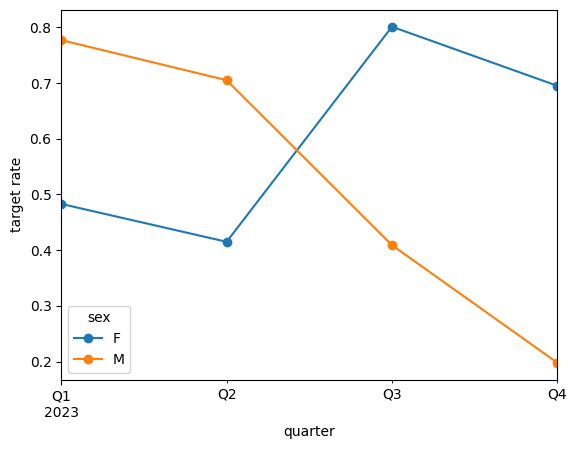

In [899]:
full_data.groupby(['quarter', 'sex'])['target'].mean().unstack(-1).plot(marker='o')
plt.ylabel('target rate');

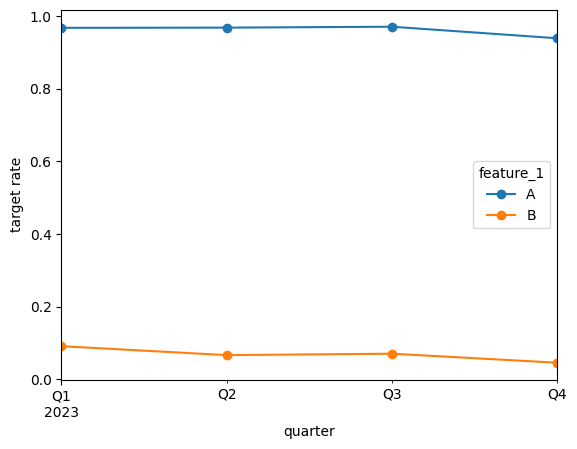

In [900]:
full_data.groupby(['quarter', 'feature_1'])['target'].mean().unstack(-1).plot(marker='o')
plt.ylabel('target rate');

In [773]:
male_q1_target = np.random.choice(['moved', 'not_moved'], size=1000, p=male_q1_target)
female_q1_target = np.random.choice(['moved', 'not_moved'], size=1000, p=[0.5, 0.5])
male_q2_target = np.random.choice(['moved', 'not_moved'], size=1000, p=[0.3, 0.7])
female_q2_target = np.random.choice(['moved', 'not_moved'], size=1000, p=[0.6, 0.4])
male_q3_target = np.random.choice(['moved', 'not_moved'], size=1000, p=[0.6, 0.4])
female_q3_target = np.random.choice(['moved', 'not_moved'], size=1000, p=[0.2, 0.8])

ValueError: 'a' and 'p' must have same size

In [396]:
from sklearn.tree import plot_tree

In [401]:
tree.tree

{'feature': 'sub_grade',
 'threshold': 0.62,
 'left': {'feature': 'sub_grade',
  'threshold': 0.5317919075144508,
  'left': {'feature': 'sub_grade',
   'threshold': 0.4666666666666667,
   'left': {'value': [0.0, 0.23644108194553368]},
   'right': {'value': [1.0, 0.5095332018408941]}},
  'right': {'value': [1.0, 0.5711678832116789]}},
 'right': {'value': [1.0, 0.6875]}}

In [405]:
tree_pred = tree.predict(X_test)

In [406]:
tree_default_pred = tree_default.predict(X_test.drop('quarter', axis=1))

In [411]:
from sklearn.metrics import roc_curve

In [412]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_stable)

In [414]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_default)

[Text(0.5, 0.875, 'x[0] <= 0.231\ngini = 0.364\nsamples = 197178\nvalue = [149951, 47227]'),
 Text(0.25, 0.625, 'x[0] <= 0.127\ngini = 0.247\nsamples = 103330\nvalue = [88381, 14949]'),
 Text(0.125, 0.375, 'x[0] <= 0.091\ngini = 0.166\nsamples = 49592\nvalue = [45067, 4525]'),
 Text(0.0625, 0.125, 'gini = 0.133\nsamples = 27807\nvalue = [25815, 1992]'),
 Text(0.1875, 0.125, 'gini = 0.206\nsamples = 21785\nvalue = [19252, 2533]'),
 Text(0.375, 0.375, 'x[0] <= 0.186\ngini = 0.313\nsamples = 53738\nvalue = [43314, 10424]'),
 Text(0.3125, 0.125, 'gini = 0.285\nsamples = 30644\nvalue = [25366, 5278]'),
 Text(0.4375, 0.125, 'gini = 0.346\nsamples = 23094\nvalue = [17948, 5146]'),
 Text(0.75, 0.625, 'x[0] <= 0.324\ngini = 0.451\nsamples = 93848\nvalue = [61570, 32278]'),
 Text(0.625, 0.375, 'x[0] <= 0.284\ngini = 0.423\nsamples = 58216\nvalue = [40541, 17675]'),
 Text(0.5625, 0.125, 'gini = 0.404\nsamples = 31546\nvalue = [22694, 8852]'),
 Text(0.6875, 0.125, 'gini = 0.443\nsamples = 26670\nv

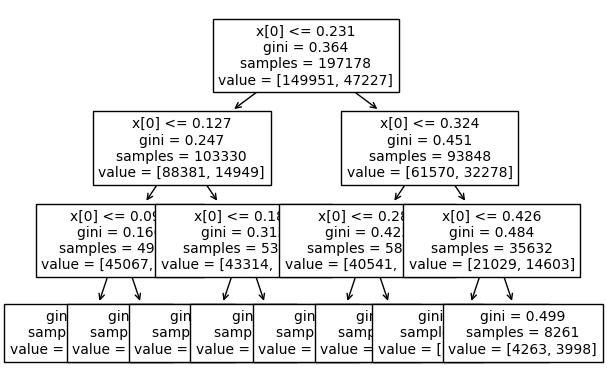

In [395]:
tree_default.tree_.

array([ 1,  2,  3, -1, -1,  6, -1, -1,  9, 10, -1, -1, 13, -1, -1],
      dtype=int64)

In [390]:
y_test_pred_stable

array([0.23644108, 0.23644108, 0.23644108, ..., 0.23644108, 0.23644108,
       0.23644108])

In [391]:
y_test_pred_stable

array([0.23644108, 0.23644108, 0.23644108, ..., 0.23644108, 0.23644108,
       0.23644108])

In [392]:
y_test_pred_default

array([0.33082115, 0.07163664, 0.2806061 , ..., 0.38745387, 0.33082115,
       0.33082115])

In [362]:
y_test

495251     0.0
495262     0.0
495264     1.0
495273     0.0
495274     0.0
          ... 
1013243    0.0
1013288    0.0
1013299    0.0
1013342    0.0
1013344    0.0
Name: target, Length: 75405, dtype: float64

In [358]:
y_test_pred_stable

array([0.22953396, 0.24701195, 0.22953396, ..., 0.24701195, 0.22953396,
       0.22953396])

In [342]:
y_test_pred_default

array([0.33052944, 0.09751434, 0.29287969, ..., 0.34443431, 0.33052944,
       0.33052944])

In [335]:
tree.feature_splits

{'initial_list_status': [0.21824152230197655, 0.22906391417094626],
 'sub_grade': [0.62,
  0.5317919075144508,
  0.4666666666666667,
  0.4570208222103577]}

In [315]:
tree.feature_splits

{'sub_grade': [0.06253735803945008],
 'grade': [0.08658893739293806],
 'initial_list_status': [0.22906391417094626]}

In [299]:
tree.feature_splits

{'sub_grade': [0.06253735803945008,
  0.3718775181305399,
  0.30711393869288606,
  0.26275693546068707,
  0.24573815780607774,
  0.21681247622670216,
  0.1754565491183879,
  0.16007695369510416]}

In [ ]:
data

In [81]:
thresholds = np.unique(X_train['funded_amnt'])
feature = 'funded_amnt'

In [83]:
tree

with ThreadPoolExecutor(max_workers=tree.n_jobs) as executor: 
    futures = []
    for threshold in tqdm(thresholds[:50]):
        if feature in tree.feature_splits and threshold in tree.feature_splits[feature]:
            continue
        else:
            futures.append(executor.submit(tree.optimization_func(X_train, y_train, feature, threshold)))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 75.73it/s]


In [86]:
threshold

2275.0

In [102]:
with ThreadPoolExecutor(max_workers=tree.n_jobs) as executor: 
    aa = executor.submit(tree.optimization_func, X_train, y_train, 'funded_amnt', thresholds[3])

In [ ]:
%%time
tree.fit(X_train, y_train)

In [97]:
tree.optimization_func(X_train, y_train, 'funded_amnt', thresholds[3])

0.0

In [103]:
aa.result()

0.0

In [87]:
tree.optimization_func(X_train, y_train, 'funded_amnt', threshold)

0

In [84]:
futures

[<Future at 0x1747bcb2700 state=finished raised TypeError>,
 <Future at 0x17484e23bb0 state=finished raised TypeError>,
 <Future at 0x17484de6730 state=finished raised TypeError>,
 <Future at 0x17484e23910 state=finished raised TypeError>,
 <Future at 0x17484dee4c0 state=finished raised TypeError>,
 <Future at 0x17484eacc70 state=finished raised TypeError>,
 <Future at 0x17484e8d7c0 state=finished raised TypeError>,
 <Future at 0x17484f63760 state=finished raised TypeError>,
 <Future at 0x17484f7a1c0 state=finished raised TypeError>,
 <Future at 0x17484f7a340 state=finished raised TypeError>,
 <Future at 0x17484f7a8b0 state=finished raised TypeError>,
 <Future at 0x17484f7aa60 state=finished raised TypeError>,
 <Future at 0x17484f7a0a0 state=finished raised TypeError>,
 <Future at 0x17484f7a2e0 state=finished raised TypeError>,
 <Future at 0x17484f7a130 state=finished raised TypeError>,
 <Future at 0x17484f7a250 state=finished raised TypeError>,
 <Future at 0x17484f7aaf0 state=finished

In [107]:
%%time
tree.fit(X_train, y_train)

 96%|█████████████████████████████████████████████████████████████████████████▊   | 1503/1568 [00:14<00:00, 103.16it/s]

KeyboardInterrupt



In [72]:
tree.best_feature_result

{'funded_amnt': 0.34281420196136736, 'funded_amnt_inv': 0.3437890454903293}

In [443]:
X_train = df[['quarter', 'total_pymnt']]
# X_train['initial_list_status'] = X_train['initial_list_status'].replace(df.groupby(['initial_list_status'])['target'].mean())
# X_train = X_train[X_train['quarter'].dt.year < 2020]
# y_train = y_train[X_train.index]
tree = DecisionTreeClassifierAsync(max_depth=6, dt_group_col='quarter', n_jobs=10, verbose=True)

In [442]:
tree.feature_splits

{}

In [365]:
joined = tree.X_list[1].join(tree.y_list[1])

In [359]:
tree.X_list[2].shape[0] + tree.X_list[1].shape[0]

272583

In [356]:
tree.X_list[1]

,quarter,grade
1,2018Q1,0.276074
6,2018Q1,0.178619
14,2018Q1,0.178619
15,2018Q1,0.276074
16,2018Q1,0.178619
...,...,...
1013226,2019Q4,0.178619
1013243,2019Q4,0.178619
1013288,2019Q4,0.276074
1013342,2019Q4,0.276074


In [390]:
tree.feature_splits

{'grade': [0.2760741412538261, 0.08658893739293806, 0.17861932519817822]}

In [408]:
joined = X_train.join(y_train)

In [410]:
joined['bins'] = pd.cut(joined['sub_grade'], bins=[-np.inf] + sorted(tree.feature_splits['sub_grade']) + [np.inf])

<Axes: xlabel='quarter'>

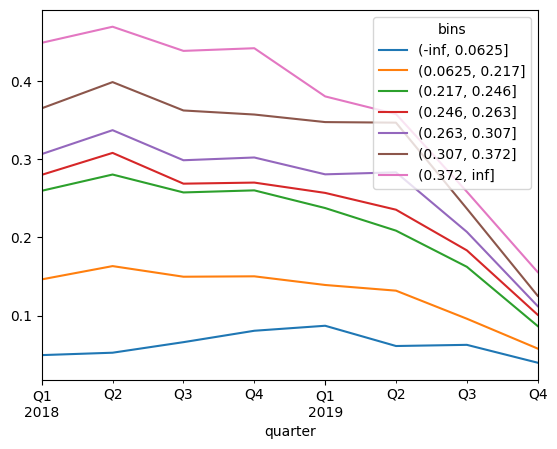

In [411]:
joined.groupby(['quarter', 'bins'])['target'].mean().unstack(-1).plot()

In [248]:
df.groupby(['grade'])['target'].mean()

grade
A    0.086589
B    0.178619
C    0.276074
D    0.347459
E    0.431474
F    0.521086
G    0.534483
Name: target, dtype: float64

In [247]:
df['grade']

0          E
1          C
6          B
13         D
14         B
          ..
1159860    A
1159862    C
1159904    A
1159989    B
1160003    B
Name: grade, Length: 276869, dtype: object

In [246]:
X_train

,quarter,funded_amnt,funded_amnt_inv
0,2018Q1,14100.0,14100.0
1,2018Q1,20000.0,20000.0
6,2018Q1,7000.0,7000.0
13,2018Q1,21000.0,21000.0
14,2018Q1,40000.0,40000.0
...,...,...,...
1159860,2020Q3,3500.0,3500.0
1159862,2020Q3,2500.0,2500.0
1159904,2020Q3,8000.0,8000.0
1159989,2020Q3,2500.0,2500.0


In [241]:
%%time
tree.fit(X_train, y_train)

CPU times: total: 1min 29s
Wall time: 4min 11s


In [244]:
%%time
preds = tree.predict(X_train)

CPU times: total: 6.95 s
Wall time: 11.3 s


In [245]:
np.unique(preds)

array([0.])

In [161]:
tree = DecisionTreeClassifierAsync(max_depth=1, dt_group_col='quarter', n_jobs=1)

In [162]:
%%time
tree.fit(X_train, y_train)

CPU times: total: 3min 8s
Wall time: 4min 34s


In [171]:
%timeit tree.calculate_gini(X_train, y_train, feature, values[0])

12.2 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [166]:
%timeit tree.calculate_psi(X_train, y_train, feature, values[0])

40.3 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [167]:
%timeit tree.calculate_target_share_intersections(X_train, y_train, feature, values[0])

42.6 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [181]:
%timeit tree.optimization_func(X_train.copy(), y_train, feature, values[0])

79.2 ms ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [190]:
y_train[X_train.loc[:, 'funded_amnt_inv'] < 14100]

6          0.0
15         1.0
19         0.0
28         0.0
29         0.0
          ... 
1159860    0.0
1159862    0.0
1159904    0.0
1159989    0.0
1160003    0.0
Name: target, Length: 150458, dtype: float64

In [191]:
%prun -s "cumulative" tree.optimization_func(X_train.copy(), y_train, feature, values[0])

In [151]:
pool = ThreadPool(12)

In [152]:
feature

'funded_amnt'

In [154]:
%%time
res = [tree.optimization_func(X, y, feature, split) for X, y, feature, split in zip(itertools.repeat(X_train), 
                                                                      itertools.repeat(y_train),
                                                                      itertools.repeat(feature),
                                                                      values[:100])]

CPU times: total: 5.45 s
Wall time: 8.88 s


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17053185081870295]

In [141]:
res[0].get()

0.0

In [198]:
### BACKUP 

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import itertools
import logging

logger = logging.getLogger("my logger")
c_handler = logging.StreamHandler()
logger.addHandler(c_handler)
logger.setLevel(logging.INFO) # <-- THIS!


class DecisionTreeClassifierAsync:
    def __init__(
        self,
        max_depth=None, 
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None, 
        dt_group_col=None,
        n_jobs=4,
        verbose=False
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.tree = None
        self.dt_group_col = dt_group_col
        self.n_jobs = n_jobs
        self.feature_splits = dict()
        self.X_list = []
        self.y_list = []
        self.intersections = []
        self.verbose = verbose
        self.best_feature_result = dict()

    def fit(self, X, y):
        self.init_X = X.copy()
        self.init_y = y.copy()
        self.tree = self.build_tree(X, y)

    def predict(self, X):
        predictions = []
        for _, sample in X.iterrows():
            predictions.append(self.predict_sample(sample))
        return np.array(predictions)

    def predict_sample(self, sample):
        node = self.tree
        while node.get('value') is None:
            if sample[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return {'value': y[0]}

        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': self.get_most_common_label(y)}

        if len(X) < self.min_samples_split:
            return {'value': self.get_most_common_label(y)}
        
        self.X_list.append(X)
        self.y_list.append(y)

        best_feature, best_threshold = self.find_best_split(X, y)
        if best_feature is None or best_threshold is None:
            return {'value': self.get_most_common_label(y)}
        
        if best_feature not in self.feature_splits:
            self.feature_splits[best_feature] = [best_threshold]
        else:
            self.feature_splits[best_feature].append(best_threshold)

        left_indices = X[best_feature] <= best_threshold
        right_indices = X[best_feature] > best_threshold

        if len(X.loc[left_indices]) < self.min_samples_leaf or len(X.loc[right_indices]) < self.min_samples_leaf:
            return {'value': self.get_most_common_label(y)}
        
        left_tree = self.build_tree(X.loc[left_indices], y[left_indices], depth + 1)
        right_tree = self.build_tree(X.loc[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold, 'left': left_tree, 'right': right_tree}
    
    def find_best_split_for_feature(self, X: pd.DataFrame, y, feature):
        best_score = 0
        best_threshold = None
        
        thresholds = np.unique(X[feature])
        
        for threshold in tqdm(thresholds):
            if feature in self.feature_splits and threshold in self.feature_splits[feature]:
                continue
            score = self.optimization_func(X, y, feature, threshold)
            if score > best_score:
                best_score = score
                best_threshold = threshold

        return feature, best_threshold, best_score
    

    def find_best_split(self, X: pd.DataFrame, y):
        best_score = 0
        best_threshold = None
        best_feature = None
        
        if self.max_features is not None:
            num_features = min(self.max_features, X.shape[1])
            features = np.random.choice(X.columns, num_features, replace=False)
            X_subset = X[features].copy(deep=True)
        else:
            features = X.columns
            X_subset = X.copy(deep=True)
            
        # кодируем категории как badrate
        features = np.delete(features, np.where(features == self.dt_group_col))
        
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:  
            futures = [
                executor.submit(self.find_best_split_for_feature, X, y, feature)
                for X, y, feature
                in zip(itertools.repeat(X_subset), 
                       itertools.repeat(y), 
                       features, 
                      )
            ]
            try:    
                for future in futures:
                    feature, threshold, score = future.result() 
                    if score > best_score:
                        best_score = score
                        best_feature = feature
                        best_threshold = threshold
            except KeyboardInterrupt:
                executor._threads.clear()
                concurrent.futures.thread._threads_queues.clear()
                raise

        return best_feature, best_threshold
    
    def optimization_func(self, X, y, feature, threshold): 
        if feature not in self.best_feature_result:
            self.best_feature_result[feature] = 0
        
        gini = self.calculate_gini(X, y, feature, threshold)
        
        if gini < self.best_feature_result[feature]:
            return 0

        if feature in self.feature_splits:
            thresholds_to_test = self.feature_splits[feature] + [threshold]
        else:
            thresholds_to_test = [threshold]
        
        thresholds_to_test = list(sorted(thresholds_to_test))
            
        self.init_X['bin_category'] = pd.cut(self.init_X[feature], bins=[-np.inf] + thresholds_to_test + [np.inf])
        
        psi = self.calculate_psi(self.init_X)
        
        if psi == 0:
            return 0
        target_share_intersection = self.calculate_target_share_intersections(self.init_X, self.init_y)
        
        if self.verbose:
            logger.debug("Feature: %s. Thresh: %.3f. GINI: %.3f. PSI: %.1f. INT: %.1f. Threshes: %s" % (feature, threshold, gini, psi, target_share_intersection, str(thresholds_to_test)))
        
        score = gini * psi * target_share_intersection
        
        if score > self.best_feature_result[feature]:
            self.best_feature_result[feature] = score
        return score

    def calculate_gini(self, X, y, feature, threshold):
        left_indices = X.loc[:, feature] <= threshold
        right_indices = X.loc[:, feature] > threshold

        left_labels = y[left_indices]
        right_labels = y[right_indices]

        left_counts = np.bincount(left_labels)
        right_counts = np.bincount(right_labels)

        left_probs = left_counts / np.sum(left_counts)
        right_probs = right_counts / np.sum(right_counts)

        left_gini = 1 - np.sum(left_probs ** 2)
        right_gini = 1 - np.sum(right_probs ** 2)

        gini = (np.sum(left_counts) * left_gini + np.sum(right_counts) * right_gini) / len(y)
        return gini
    
    def calculate_psi(self, X):
        cnt_table = X.groupby([self.dt_group_col, 'bin_category']).size().unstack(1)
        shares_table = cnt_table.apply(lambda x: x / x.sum(), axis=1)
        
        actual = shares_table.iloc[-1]
        reference = shares_table.iloc[:-1]
        
        psi = ((reference - actual) * np.log(reference / (actual + 1e-5) + 1e-5)).sum(axis=1)

        if any(psi.values >= 0.2):
            return 0
        elif any(psi.values >= 0.1):
            return 0.5
        else:
            return 1
        
    def calculate_target_share_intersections(self, X, y):   
        full_df = X.join(y)
        target_rate_df = full_df.groupby([self.dt_group_col, 'bin_category'])['target'].mean().unstack(-1)
        self.intersections.append(target_rate_df)
        increasing = True
        decreasing = True
        for i in range(len(target_rate_df.columns) - 1):
            col1 = target_rate_df.columns[i]
            col2 = target_rate_df.columns[i + 1]
            increasing *= all(target_rate_df[col1] <= target_rate_df[col2])
            decreasing *= all(target_rate_df[col1] > target_rate_df[col2])
        result = increasing or decreasing
        return result

    def get_most_common_label(self, y):
        unique_labels, counts = np.unique(y, return_counts=True)
        most_common_label = unique_labels[np.argmax(counts)]
        return most_common_label

In [127]:
tree.fit(X_train, y_train)

  8%|██████▋                                                                        | 132/1554 [00:17<03:12,  7.39it/s]


 17%|█████████████▌                                                                 | 267/1554 [00:33<02:34,  8.34it/s]


 26%|████████████████████▎                                                          | 400/1554 [00:50<02:22,  8.10it/s]


 34%|███████████████████████████▏                                                   | 534/1554 [01:07<02:03,  8.27it/s]


 43%|██████████████████████████████████                                             | 669/1554 [01:24<01:51,  7.96it/s]


 52%|████████████████████████████████████████▊                                      | 804/1554 [01:41<01:32,  8.09it/s]


 60%|███████████████████████████████████████████████▋                               | 938/1554 [01:59<01:16,  8.01it/s]


 69%|█████████████████████████████████████████████████████▉                        | 1074/1554 [02:17<01:03,  7.51it/s]


 78%|████████████████████████████████████████████████████████████▊                 | 1211/1554 [02:34<00:38,  9.01it/s]


 87%|███████████████████████████████████████████████████████████████████▌          | 1346/1554 [02:50<00:25,  8.18it/s]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1481/1554 [03:06<00:07,  9.16it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1554/1554 [03:16<00:00,  7.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1568/1568 [03:20<00:00,  7.82it/s]


KeyboardInterrupt: 

In [89]:
%%time
def count_power_ten(x):
    time.sleep(1)
    return x ** 150000


output = []
for i in tqdm(range(10)):
    output.append(count_power_ten(i))

 40%|█████████████████████████████████▏                                                 | 4/10 [00:05<00:07,  1.26s/it]


KeyboardInterrupt: 

In [ ]:
futures = []
            
            for feature in features:
                futures.append(executor.submit(self.find_best_split_for_feature, X, y, feature))
                
            for future in futures:
                feature, threshold, score = future.result() 
                if score < best_score:
                    best_score = score
                    best_feature = feature
                    best_threshold = threshold


In [91]:
feature = 'funded_amnt'
values = X_train[feature].unique()


0.0

In [92]:
for val in tqdm(values):
    tree.optimization_func(X_train, y_train, feature, val)

  2%|█▊                                                                              | 35/1554 [00:03<02:21, 10.72it/s]


KeyboardInterrupt: 

In [110]:
import itertools

In [115]:
%%time

import time

def count_power_ten(x):
    time.sleep(1)
    return x ** 150000


output = []
futures = []
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = [
        executor.submit(tree.optimization_func, X_train, y_train, feature, val)
        for X_train, y_train, feature, val 
        in zip(itertools.repeat(X_train), 
               itertools.repeat(y_train), 
               itertools.repeat(feature), 
               values[:100],
              )
    ]
    for future in tqdm(futures):
        output.append(future.result())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.68it/s]

CPU times: total: 938 ms
Wall time: 4.62 s


In [83]:
from time import sleep, perf_counter

def task(id):
    print(f'Начинаем задачу {id}...')
    sleep(1)
    return f'Закончили задачу {id}'

start = perf_counter()

print(task(1))
print(task(2))

finish = perf_counter()

print(f"Выполнение заняло {finish-start} секунд.")

Начинаем задачу 1...
Закончили задачу 1
Начинаем задачу 2...
Закончили задачу 2
Выполнение заняло 2.0095994000002975 секунд.


In [84]:
from time import sleep, perf_counter
from concurrent.futures import ThreadPoolExecutor

def task(id):
    print(f'Начинаем задачу {id}...')
    sleep(1)
    return f'Закончили задачу {id}'

start = perf_counter()

with ThreadPoolExecutor() as executor:
    f1 = executor.submit(task, 1)
    f2 = executor.submit(task, 2)

    print(f1.result())
    print(f2.result())    

finish = perf_counter()

print(f"Выполнение заняло {finish-start} секунд.")

Начинаем задачу 1...
Начинаем задачу 2...
Закончили задачу 1
Закончили задачу 2
Выполнение заняло 1.0188797000000704 секунд.


In [69]:
for future in tqdm(futures):
    output.append(future.result())

100%|████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<?, ?it/s]


In [49]:
tree.fit(X_train, y_train)

KeyboardInterrupt: 

In [12]:
tree.calculate_psi(X_train, y_train, best_feature, best_split)

0.5

In [15]:
tree.calculate_target_share_intersections(X_train, y_train, best_feature, best_split)

1

In [16]:
X_copy = X_train.copy(deep=True)

In [19]:
X_copy['bin_category'] = pd.cut(X_copy[best_feature], bins=[-np.inf] + [best_split] + [np.inf])
target_rate_df = X_copy.groupby(['quarter', 'bin_category']).size().unstack(1)

In [23]:
full_df = X_copy.join(y_train)

<Axes: xlabel='quarter'>

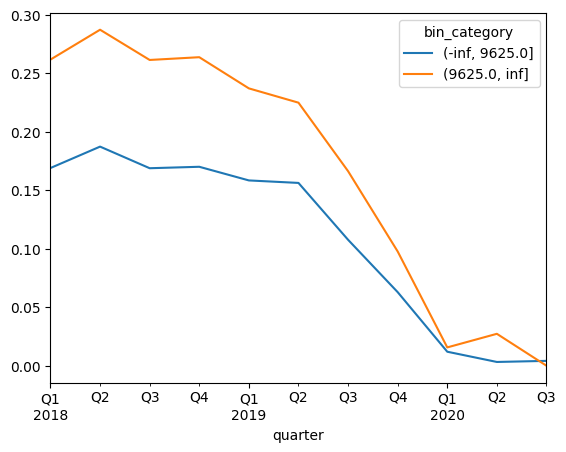

In [30]:
full_df.groupby(['quarter', 'bin_category'])['target'].mean().unstack(1).plot()

In [21]:
X_copy

,quarter,funded_amnt,funded_amnt_inv,bin_category
0,2018Q1,14100.0,14100.0,"(9625.0, inf]"
1,2018Q1,20000.0,20000.0,"(9625.0, inf]"
6,2018Q1,7000.0,7000.0,"(-inf, 9625.0]"
13,2018Q1,21000.0,21000.0,"(9625.0, inf]"
14,2018Q1,40000.0,40000.0,"(9625.0, inf]"
...,...,...,...,...
1159860,2020Q3,3500.0,3500.0,"(-inf, 9625.0]"
1159862,2020Q3,2500.0,2500.0,"(-inf, 9625.0]"
1159904,2020Q3,8000.0,8000.0,"(-inf, 9625.0]"
1159989,2020Q3,2500.0,2500.0,"(-inf, 9625.0]"


In [20]:
target_rate_df

bin_category,"(-inf, 9625.0]","(9625.0, inf]"
quarter,,
2018Q1,16735,37189
2018Q2,18031,38884
2018Q3,14544,32624
2018Q4,12851,26320
2019Q1,8641,18867
2019Q2,7620,15117
2019Q3,5999,10604
2019Q4,3306,5251
2020Q1,1253,1724


In [ ]:
X_train

In [9]:
best_feature, best_split = tree.find_best_split(X_train, y_train)

100%|██████████████████████████████████████████████████████████████████████████████| 1568/1568 [01:15<00:00, 20.74it/s]


In [10]:
best_feature

'funded_amnt_inv'

In [11]:
best_split

9625.0

In [8]:
tree.fit(X_train, y_train)

100%|██████████████████████████████████████████████████████████████████████████████| 1568/1568 [01:14<00:00, 21.10it/s]


InvalidIndexError: (slice(None, None, None), 'funded_amnt_inv')

In [25]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split


X, y = make_classification(n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)
sklearn_tree = DT()
sklearn_tree.fit(X_train, y_train)

roc_test = accuracy_score(y_test, sklearn_tree.predict(X_test))
roc_test

0.86

In [26]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.86

DecisionTreeClassifier()

In [105]:
contingency_table = pd.crosstab(df['grade'], df['target'])

In [108]:
expected = np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / contingency_table.sum().sum()

In [110]:
chi_squared = ((contingency_table - expected)**2 / expected).sum().sum()

In [116]:
((contingency_table - expected)**2 / expected).sum(axis=1)

grade
A    7488.701912
B     744.044701
C    1304.203368
D    4338.711753
E    2829.862151
F     916.456341
G     234.490873
dtype: float64

In [123]:
contingency_table.apply(lambda x: x / x.sum(), axis=1)

target,0.0,1.0
grade,,
A,0.913411,0.086589
B,0.821381,0.178619
C,0.723926,0.276074
D,0.652541,0.347459
E,0.568526,0.431474
F,0.478914,0.521086
G,0.465517,0.534483


In [120]:
acontingency_table.sum(axis=1) / contingency_table.sum().sum()

array([[56478.63564357, 15909.36435643],
       [58759.2215416 , 16551.7784584 ],
       [55058.63347648, 15509.36652352],
       [35606.94445026, 10030.05554974],
       [ 8448.23267321,  2379.76732679],
       [ 1350.56250068,   380.43749932],
       [  316.7697142 ,    89.2302858 ]])

In [119]:
pd.crosstab(df['grade'], df['target']).

target,0.0,1.0
grade,,
A,66120,6268
B,61859,13452
C,51086,19482
D,29780,15857
E,6156,4672
F,829,902
G,189,217


In [118]:
pd.cut(df['grade'], ['A', 'C'])

ValueError: could not convert string to float: 'A'

In [112]:
((contingency_table - expected)**2 / expected).sum()

target
0.0     3924.477880
1.0    13931.993217
dtype: float64

In [111]:
chi_squared

17856.47109703683

In [113]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def chi_squared_split(feature, target):
    # Создание таблицы сопряженности
    contingency_table = pd.crosstab(feature, target)
    
    # Вычисление ожидаемого количества наблюдений
    expected = np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / contingency_table.sum().sum()
    
    # Вычисление статистики хи-квадрат для каждой ячейки
    chi_squared = ((contingency_table - expected)**2 / expected).sum().sum()
    
    return chi_squared

# Пример использования
data = pd.DataFrame({'Feature': ['A', 'B', 'C', 'D', 'E'],
                     'Target': [1, 0, 1, 1, 0]})

chi_squared_split(data['Feature'], data['Target'])

5.0

In [28]:
feature = 3
threshold = 0.5

In [45]:
features = df[['quarter', 'funded_amnt', 'funded_amnt_inv', 'installment']]

In [46]:
feature = 'funded_amnt'
threshold = 20000

In [47]:
left = df[df[feature] <= threshold]
right = df[df[feature] > threshold]

In [55]:
df['bin_category'] = pd.cut(df[feature], bins=[-np.inf] + [threshold] + [np.inf])

In [69]:
cnt_table = df.groupby(['quarter', 'bin_category']).count()[['id']].unstack(1)

In [100]:
df.groupby(['quarter', 'bin_category']).size().unstack(1)

bin_category,"(-inf, 20000.0]","(20000.0, inf]"
quarter,,
2018Q1,40217,13707
2018Q2,42929,13986
2018Q3,35684,11484
2018Q4,29812,9359
2019Q1,20664,6844
2019Q2,17119,5618
2019Q3,12682,3921
2019Q4,6574,1983
2020Q1,2256,721


In [72]:
shares_table = cnt_table.apply(lambda x: x / x.sum(), axis=1)

In [73]:
actual = shares_table.iloc[-1]
reference = shares_table.iloc[:-1]
psi = ((reference - actual) * np.log(reference / (actual + 1e-5) + 1e-5)).sum(axis=1)

In [74]:
psi

quarter
2018Q1    0.110748
2018Q2    0.098044
2018Q3    0.094750
2018Q4    0.088284
2019Q1    0.102576
2019Q2    0.100031
2019Q3    0.084442
2019Q4    0.078445
2020Q1    0.092910
2020Q2    0.117456
Freq: Q-DEC, dtype: float64

In [77]:
any(psi.values > 0.2)

False

In [76]:
any(psi.values > 0.1)

True

C:\Users\anana\AppData\Local\Temp\ipykernel_3452\397749278.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  target_rate_df = df.groupby(['quarter', 'bin_category']).mean()[['target']].unstack(1)


In [96]:
df['bin_category'] = pd.cut(df[feature], bins=[-np.inf] + [threshold] + [np.inf])
target_rate_df = df.groupby(['quarter', 'bin_category']).mean()[['target']].unstack(1)
increasing = True
decreasing = True
for i in range(len(target_rate_df.columns) - 1):
    col1 = target_rate_df.columns[i]
    col2 = target_rate_df.columns[i + 1]
    increasing *= all(target_rate_df[col1] <= target_rate_df[col2])
    decreasing *= all(target_rate_df[col1] > target_rate_df[col2])

<Axes: xlabel='quarter'>

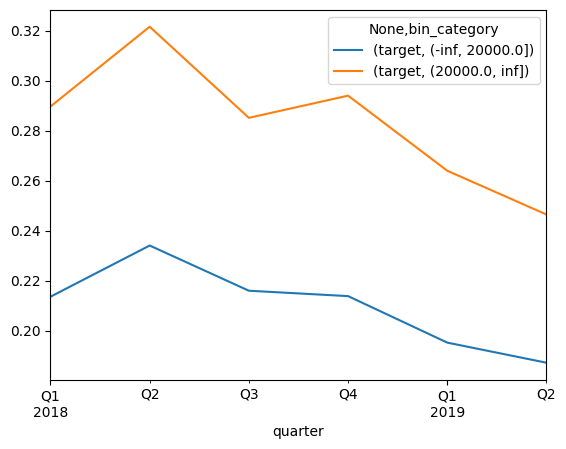

In [98]:
target_rate_df.plot()

In [97]:
increasing or decreasing

1

In [90]:
all(target_rate_df[col1] > target_rate_df[col2])

False

In [87]:
target_rate_df.columns

MultiIndex([('target', (-inf, 20000.0]),
            ('target',  (20000.0, inf])],
           names=[None, 'bin_category'])

<Axes: xlabel='quarter'>

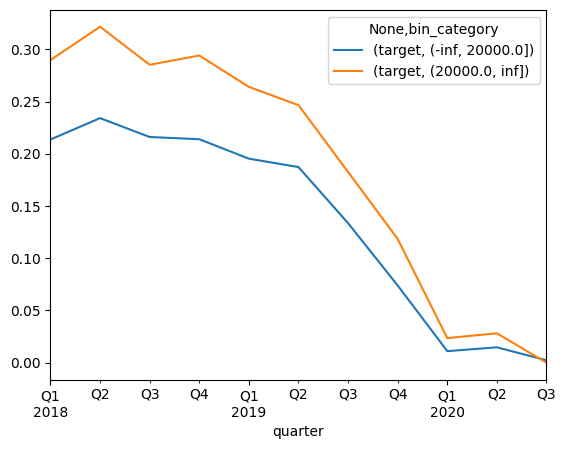

In [85]:
target_rate_df.plot()

In [68]:
unstacked

id               
bin_category (-inf, 20000.0] (20000.0, inf]
quarter                                    
2018Q1                 40217          13707
2018Q2                 42929          13986
2018Q3                 35684          11484
2018Q4                 29812           9359
2019Q1                 20664           6844
2019Q2                 17119           5618
2019Q3                 12682           3921
2019Q4                  6574           1983
2020Q1                  2256            721
2020Q2                   611            213
2020Q3                   424             61

In [124]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

class Node:
    def __init__(self, feature=None, split_value=None, children=None, target=None):
        self.feature = feature
        self.split_value = split_value
        self.children = children
        self.target = target

def chi_squared_split(feature, target):
    contingency_table = pd.crosstab(feature, target)
    _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

def chaid(dataset, target_col, alpha=0.05):
    target = dataset[target_col]
    features = dataset.drop(target_col, axis=1)
    
    # Проверка условий остановки
    if len(set(target)) == 1:
        return Node(target=target.iloc[0])
    
    if features.empty or features.shape[1] == 0:
        return Node(target=target.mode().iloc[0])
    
    # Выбор признака с наименьшим p-value
    best_feature = None
    best_p_value = np.inf
    best_split_value = None
    
    for feature in features.columns:
        p_values = []
        
        for value in set(features[feature]):
            p_value = chi_squared_split(features[feature] <= value, target)
            p_values.append(p_value)
        
        min_p_value = min(p_values)
        min_p_value_index = p_values.index(min_p_value)
        split_value = sorted(set(features[feature]))[min_p_value_index]
        
        if min_p_value < best_p_value:
            best_feature = feature
            best_p_value = min_p_value
            best_split_value = split_value
    
    # Проверка условия остановки на основе alpha
    if best_p_value > alpha:
        return Node(target=target.mode().iloc[0])
    
    # Рекурсивное создание дочерних узлов
    left_data = dataset[features[best_feature] <= best_split_value]
    right_data = dataset[features[best_feature] > best_split_value]
    
    left_child = chaid(left_data, target_col, alpha)
    right_child = chaid(right_data, target_col, alpha)
    
    return Node(feature=best_feature, split_value=best_split_value, children=[left_child, right_child])

# Пример использования
data = pd.DataFrame({'Feature1': [1, 2, 3, 4, 5],
                     'Feature2': ['A', 'B', 'A', 'B', 'A'],
                     'Target': [0, 1, 0, 1, 1]})

tree = chaid(data, 'Target')

In [125]:
tree

In [67]:
unstacked / unstacked.sum(axis=1)

ValueError: cannot join with no overlapping index names

In [ ]:
np.where(df[feature] <= threshold)

In [44]:
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,year,date,quarter,target
0,130607974,14100.0,14100.0,14100.0,36 months,23.87%,552.23,E,E2,Sr Clinical Research Associate,...,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01,2018Q1,0.0
1,130932509,20000.0,20000.0,20000.0,60 months,14.07%,466.10,C,C3,TEACHER,...,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01,2018Q1,1.0
6,130910225,7000.0,7000.0,7000.0,36 months,11.98%,232.44,B,B5,Parole,...,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01,2018Q1,0.0
13,130942737,21000.0,21000.0,21000.0,60 months,20.39%,560.94,D,D4,Machine operator,...,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01,2018Q1,0.0
14,130951046,40000.0,40000.0,40000.0,60 months,9.43%,838.71,B,B1,Private Mortgage Banker,...,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01,2018Q1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159860,169156034,3500.0,3500.0,3500.0,36 months,10.81%,114.28,A,A5,Chief Financial Officer,...,NaN,None,0.0,0.0,3335.75,N,2020,2020-07-01,2020Q3,0.0
1159862,169228088,2500.0,2500.0,2500.0,36 months,18.24%,90.69,C,C2,Janitor,...,NaN,None,NaN,NaN,NaN,N,2020,2020-07-01,2020Q3,0.0
1159904,169187392,8000.0,8000.0,8000.0,36 months,10.19%,258.86,A,A4,Mod. Eng.,...,NaN,None,NaN,NaN,NaN,N,2020,2020-07-01,2020Q3,0.0
1159989,169086928,2500.0,2500.0,2500.0,36 months,14.71%,86.31,B,B3,None,...,NaN,None,0.0,0.0,2462.37,N,2020,2020-07-01,2020Q3,0.0


In [29]:
left_indices = X[:, feature] <= threshold
right_indices = X[:, feature] > threshold

In [31]:
left_labels = y[left_indices]
right_labels = y[right_indices]

In [34]:
left_counts = np.bincount(left_labels)
right_counts = np.bincount(right_labels)

In [35]:
left_counts

array([349, 343], dtype=int64)

In [36]:
right_counts

array([151, 157], dtype=int64)

In [37]:
left_probs = left_counts / np.sum(left_counts)
right_probs = right_counts / np.sum(right_counts)

In [38]:
left_probs

array([0.50433526, 0.49566474])

In [39]:
right_probs

array([0.49025974, 0.50974026])

In [ ]:
left_indices = X[:, feature] <= threshold
right_indices = X[:, feature] > threshold

left_labels = y[left_indices]
right_labels = y[right_indices]

left_counts = np.bincount(left_labels)
right_counts = np.bincount(right_labels)

left_probs = left_counts / np.sum(left_counts)
right_probs = right_counts / np.sum(right_counts)

left_gini = 1 - np.sum(left_probs ** 2)
right_gini = 1 - np.sum(right_probs ** 2)

gini = (np.sum(left_counts) * left_gini + np.sum(right_counts) * right_gini) / len(y)

In [22]:
roc_auc_score(y, sklearn_tree.predict_proba(X)[:, 1])

1.0

In [3]:
X = np.random.rand(100, 5)

In [7]:
y = np.random.randint(0, 2, size=(100))

In [9]:
tree = DecisionTreeClassifier()

In [10]:
tree.fit(X, y)

In [12]:
y

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1])

In [11]:
tree.predict(X)

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1])

In [8]:
y

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1])

In [44]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


class RiskTreeNode():
    def __init__(self, feature_name, criterion_type='gini'):
        self.feature_name = feature_name
        self.left = None
        self.right = None
        self.criterion_type = criterion_type
        
    def fit(self, X, y, splits):
        criterion_list = []
        for split in splits:
            criterion = self._criterion(X, y, split)
            criterion_list.append(criterion)
        pass
    
    def _criterion_gini_count(self, y):
        p1 = np.mean(y)
        p0 = 1 - p1
        gini = 1 - (p1 ** 2 + p0 ** 2)
        return gini
    
    def _criterion_gini(self, X, y, split):
        left_mask = X < split
        left_y = y[left_mask]
        gini_left = self._criterion_gini_count(left_y)
        left_size = len(left_y)

        right_mask = X >= split
        right_y = y[right_mask]
        gini_right = self._criterion_gini_count(right_y)
        right_size = len(right_y)

        children_gini = (left_size / total_size) * gini_left + (right_size / total_size) * gini_right

        delta_gini = gini_head - children_gini
        return delta_gini
    
    def _criterion_entropy(self, X, y, split):
        pass
    
    def _risk_stability(self, X, y, split):
        pass
    
    def _calc_psi(self, X, y, split):
        pass
    
    def _criterion(self, X, y, split):
        if self.criterion_type == 'gini':
            criterion = self._criterion_gini(X[self.feature_name], y, split)
        elif self.criterion_type == 'entropy':
            criterion = self._criterion_entropy(X[self.feature_name], y, split)
        else:
            raise NotImplementedError("No criterion method implemented, try 'gini' or 'entropy'")
        risk_stability = self._risk_stability(X, y, split)
        psi = self._calc_psi(X, y, split)
        total_criterion = criterion * risk_stability * psi
        return total_criterion


class RiskTree(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_col, period_col):
        self.feature_col = feature_col
        self.period_col = period_col
        self.head_node = None

    def fit(self, X, y):
        splits = sorted(X[self.feature_col].unique())
        head_node = RiskTreeNode(feature_name=self.feature_col)
        
        # Two paths. Just return the object, or implement here your decision rules
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # Change this to your decision tree "rules"
        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]
    
    
class RiskForest(BaseEstimator, ClassifierMixin):
    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param
        self.date_col = None
        self.trees = []
        self.period_col_name = "period"
        
    def _check_datetime_col(self, X):
        if not pd.api.types.is_datetime64_any_dtype(X[self.date_col]):
            raise pd.errors.DataError("Expected to date_col is datetime type, but got %s" % X[self.date_col].dtype)
            
    def _check_nan_in_target(self, y):
        num_nans = pd.isna(y).sum()
        if num_nans > 0:
            raise Exception("Target col should not have include NaN values")
            
    def _get_all_features_from_X(self, X):
        features = X.drop(self.date_col, axis=1).columns.to_list()
        return features
    
    @staticmethod
    def split_df_to_period(df, date_col, freq='Q', period_col_name='period'):
        splitted_df = df.copy(deep=True)
        splitted_df[period_col_name] = splitted_df[date_col].dt.to_period(freq)
        return splitted_df
        
    def fit(self, X, y, date_col):
        check_X_y(X, y)
        self.date_col = date_col
        self._check_datetime_col(X)
        self._check_nan_in_target(y)
        self.features = self._get_all_features_from_X(X)
        self.splitted_df = self.split_df_to_period(X, self.date_col, period_col_name=self.period_col_name)
        
        for fearure in self.features:
            tree = RiskTree(feature_col=feature, period_col=self.period_col_name)
            tree.fit(X[feature, self.period_col_name], y)
            self.trees.append(tree)

        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # Change this to your decision tree "rules"
        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]

In [32]:
import sklearn

In [45]:
rf = RiskForest()
rf.fit(df.drop(["target"], axis=1), df['target'], "date")

ValueError: Input contains NaN

In [34]:
rf.features

['id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verificat

In [3]:
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,year,date
0,130607974,14100.0,14100.0,14100.0,36 months,23.87%,552.23,E,E2,Sr Clinical Research Associate,...,None,NaN,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01
1,130932509,20000.0,20000.0,20000.0,60 months,14.07%,466.10,C,C3,TEACHER,...,None,NaN,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01
2,130938452,28625.0,28625.0,28625.0,60 months,21.85%,788.16,D,D5,Psychologist,...,None,NaN,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01
3,130950844,20000.0,20000.0,20000.0,60 months,9.92%,424.16,B,B2,Manager,...,None,NaN,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01
4,130966126,15000.0,15000.0,15000.0,60 months,17.47%,376.59,D,D1,CCAP Administrator,...,None,NaN,NaN,None,NaN,NaN,NaN,N,2018,2018-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160061,169147100,22500.0,22500.0,22500.0,36 months,20.74%,844.69,C,C5,"Manager, Special Events",...,None,NaN,NaN,None,NaN,NaN,NaN,N,2020,2020-07-01
1160062,169167676,6000.0,6000.0,6000.0,36 months,20.74%,225.26,C,C5,Labor worker,...,None,NaN,NaN,None,NaN,NaN,NaN,N,2020,2020-07-01
1160063,169157465,24000.0,24000.0,24000.0,36 months,19.12%,881.21,C,C3,Sr. Clinical Trial Manager,...,None,NaN,NaN,None,NaN,NaN,NaN,N,2020,2020-07-01
1160064,168972094,31550.0,31550.0,31550.0,36 months,19.12%,1158.42,C,C3,Marketing,...,None,NaN,NaN,None,NaN,NaN,NaN,N,2020,2020-07-01


# data preprocessing

In [15]:
data = pd.read_csv("../data/external/Loan_status_2007-2020Q3.gzip/Loan_status_2007-2020Q3.gzip")
data = data[data['issue_d'].notna()]
data['year'] = data['issue_d'].apply(lambda x: x.split("-")[-1]).astype(int)
data = data[data['year'] >= 2018].reset_index(drop=True)
data.drop(data.columns[0], axis=1, inplace=True)
data['date'] = pd.to_datetime(data['issue_d'], format="%b-%Y")
data.to_parquet("../data/raw/data.parquet")

C:\Users\anana\AppData\Local\Temp\ipykernel_25052\1900112796.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/external/Loan_status_2007-2020Q3.gzip/Loan_status_2007-2020Q3.gzip")
